In [1]:
import os
import numpy as np
import scipy.stats as st
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('figure', dpi=200)
plt.rc('legend', fontsize=9)
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def combine_results(results):
    num_configs, num_runs, num_policies, num_evals = results.shape
    mean_evals = np.mean(results, axis=3)
    mean_runs = np.mean(mean_evals, axis=1)
    sem_runs = st.sem(mean_evals, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_runs, scale=sem_runs)
    return mean_runs, lower, upper

In [4]:
etd_algs = ['ace-trace-etd-episodic', 'ace-trace-etd-uniform', 'offpac-etd', 'ace-direct-etd-episodic', 'ace-direct-etd-uniform', 'ace-ideal-etd-episodic', 'ace-ideal-etd-uniform']
tdrc_algs = ['ace-trace-tdrc-episodic', 'ace-trace-tdrc-uniform', 'offpac-tdrc', 'ace-direct-tdrc-episodic', 'ace-direct-tdrc-uniform', 'ace-ideal-tdrc-episodic', 'ace-ideal-tdrc-uniform']
algs = etd_algs + tdrc_algs

ace-trace-etd-episodic (0.00048828, 0.5, 0., 0.875, 1., 0.95, [2, 2], 2, True)
ace-trace-etd-uniform (6.10351562e-05, 0.00390625, 0., 0.875, 1., 0.95, [2, 2], 2, True)
ace-ideal-etd-episodic (0.00024414, 0.25, 0., 0.875, 1., 0.95, [2, 2], 2, True)
ace-ideal-etd-uniform (6.10351562e-05, 0.0078125, 0., 0.875, 1., 0.95, [2, 2], 2, True)


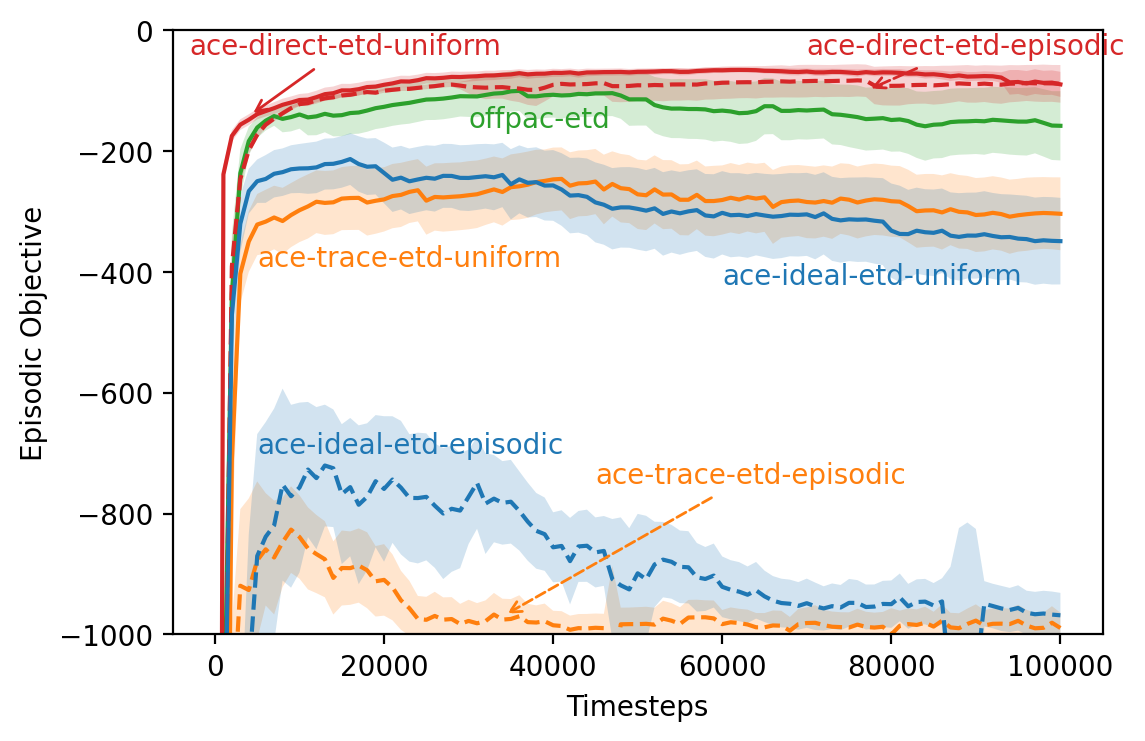

In [16]:
fig, ax = plt.subplots()
for alg in etd_algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-episodic/'+alg+'/sweep0/performance.npy', mode='r')
    results = performance['results']
    means, lower, upper = combine_results(results)
    best_config = np.nanargmax(means.sum(axis=1))
    x = np.linspace(0, 100000, 101)
    y = means[best_config]
    
    linestyle = '--' if 'episodic' in alg else '-'
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(4000, -142), xytext=(-3000, -40), arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(77000, -100), xytext=(70000, -40), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'trace' in alg:
        print(alg, performance['parameters'][best_config])
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(5000, -390))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(34000, -970), xytext=(45000, -750), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, color=color, xy=(30000, -160))
    elif 'ideal' in alg:
        print(alg, performance['parameters'][best_config])
        color = 'tab:blue'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(60000, -420))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(5000, -700))
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)
    
ax.set_xlabel('Timesteps')
ax.set_ylabel('Episodic Objective')
ax.set_ylim(-1000,0)
# ax.legend(loc='lower right')
plt.savefig('pw_epi_etd.png', bbox_inches="tight")

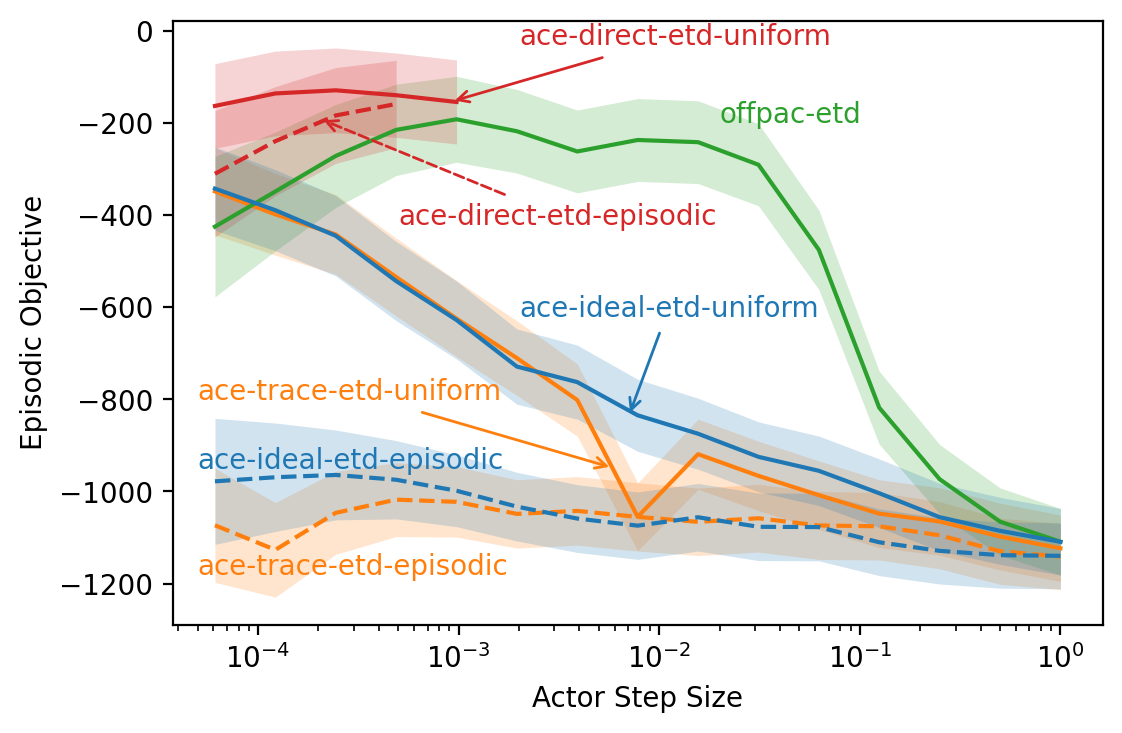

In [306]:
fig, ax = plt.subplots()
for alg in etd_algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-episodic/'+alg+'/sweep0/performance.npy', mode='r')
    results = performance['results']
    means, lower, upper = combine_results(results)
    _, num_runs, _, _ = results.shape
    mean_return = np.mean(means, axis=1)
    sem_return = st.sem(means, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_return, scale=sem_return)
    best_config = np.nanargmax(mean_return)
    
    parameters = performance['parameters']
    mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
            (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
            (parameters['lambda'] == parameters[best_config]['lambda'])
    sorted_indices = np.argsort(parameters[mask]['alpha_a'])
    
    x = parameters[mask]['alpha_a'][sorted_indices]
    y = mean_return[mask][sorted_indices]

    linestyle = '--' if 'episodic' in alg else '-'
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0009, -155), xytext=(.002, -30), arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.0002, -190), xytext=(.0005, -420), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'trace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.006, -950), xytext=(.00005, -800), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.00005, -1180))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, color=color, xy=(.02, -200))
    elif 'ideal' in alg:
        color = 'tab:blue'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.007, -840), xytext=(.002, -620), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.00005, -950))
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[mask][sorted_indices], upper[mask][sorted_indices], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Actor Step Size')
ax.set_ylabel('Episodic Objective')
ax.set_xscale('log')
plt.savefig('pw_epi_etd_sens.png', bbox_inches="tight")

ace-trace-tdrc-episodic (0.00048828, 0.125, 0., 0.5, 1., 0.95, [2, 2], 2, True)
ace-trace-tdrc-uniform (0.00012207, 0.015625, 0., 0.75, 1., 0.95, [2, 2], 2, True)
ace-ideal-tdrc-episodic (0.00097656, 0.125, 0., 0.5, 1., 0.95, [2, 2], 2, True)
ace-ideal-tdrc-uniform (6.10351562e-05, 0.015625, 0., 0.75, 1., 0.95, [2, 2], 2, True)


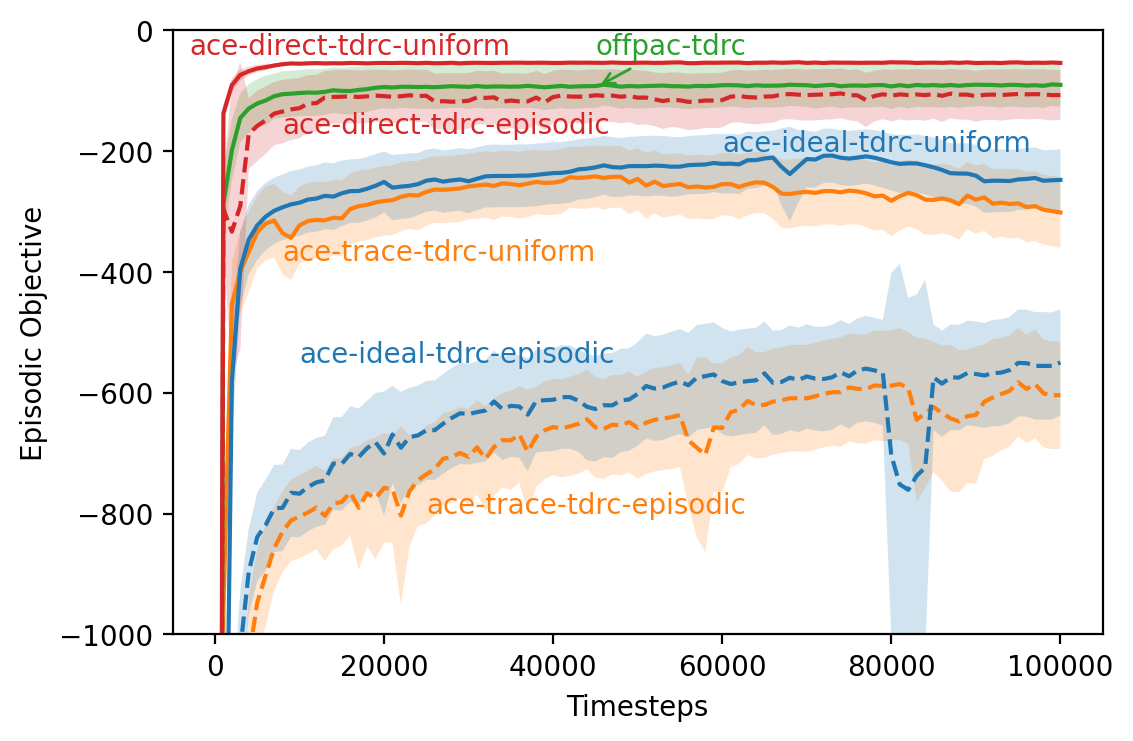

In [17]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-episodic/'+alg+'/sweep0/performance.npy', mode='r')
    results = performance['results']
    means, lower, upper = combine_results(results)
    best_config = np.nanargmax(means.sum(axis=1))
    x = np.linspace(0, 100000, 101)
    y = means[best_config]
    linestyle = '--' if 'episodic' in alg else '-'
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(-3000, -40))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(8000, -170))
    elif 'trace' in alg:
        print(alg, performance['parameters'][best_config])
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(8000, -380))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(25000, -800))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, color=color, xy=(45000, -95), xytext=(45000, -40), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'ideal' in alg:
        print(alg, performance['parameters'][best_config])
        color = 'tab:blue'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(60000, -200))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(10000, -550))
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)
    
ax.set_xlabel('Timesteps')
ax.set_ylabel('Episodic Objective')
ax.set_ylim(-1000,0)
plt.savefig('pw_epi_tdrc.png', bbox_inches="tight")

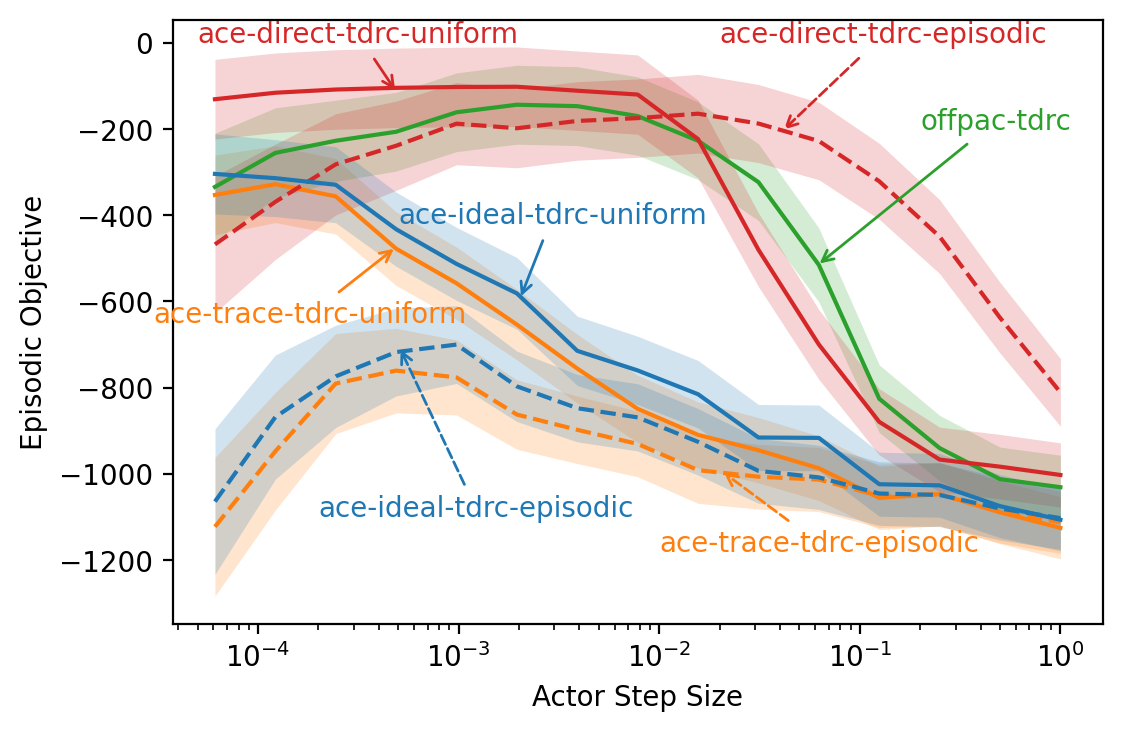

In [368]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-episodic/'+alg+'/sweep0/performance.npy', mode='r')
    results = performance['results']
    means, lower, upper = combine_results(results)
    _, num_runs, _, _ = results.shape
    mean_return = np.mean(means, axis=1)
    sem_return = st.sem(means, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_return, scale=sem_return)
    best_config = np.nanargmax(mean_return)
    
    parameters = performance['parameters']
    mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
            (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
            (parameters['lambda'] == parameters[best_config]['lambda'])
    sorted_indices = np.argsort(parameters[mask]['alpha_a'])
    
    x = parameters[mask]['alpha_a'][sorted_indices]
    y = mean_return[mask][sorted_indices]
    
    linestyle = '--' if 'episodic' in alg else '-'
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0005, -120), xytext=(.00005, 0), arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.04, -210), xytext=(.02, 0), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'trace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0005, -470), xytext=(.00003, -650), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.02, -990), xytext=(.01, -1180), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, color=color, xy=(.06, -520), xytext=(.2, -200), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'ideal' in alg:
        color = 'tab:blue'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.002, -600), xytext=(.0005, -420), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.0005, -700), xytext=(.0002, -1100), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[mask][sorted_indices], upper[mask][sorted_indices], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Actor Step Size')
ax.set_ylabel('Episodic Objective')
ax.set_xscale('log')
plt.savefig('pw_epi_tdrc_sens.png', bbox_inches="tight")

ace-trace-etd-episodic (0.00097656, 1., 0., 0.9375, 1., 0.95, [2, 2], 2, True)
ace-trace-etd-uniform (6.10351562e-05, 0.00048828, 0., 0., 1., 0.95, [2, 2], 2, True)
ace-ideal-etd-episodic (0.00097656, 1., 0., 0.5, 1., 0.95, [2, 2], 2, True)
ace-ideal-etd-uniform (6.10351562e-05, 0.00195312, 0., 0., 1., 0.95, [2, 2], 2, True)


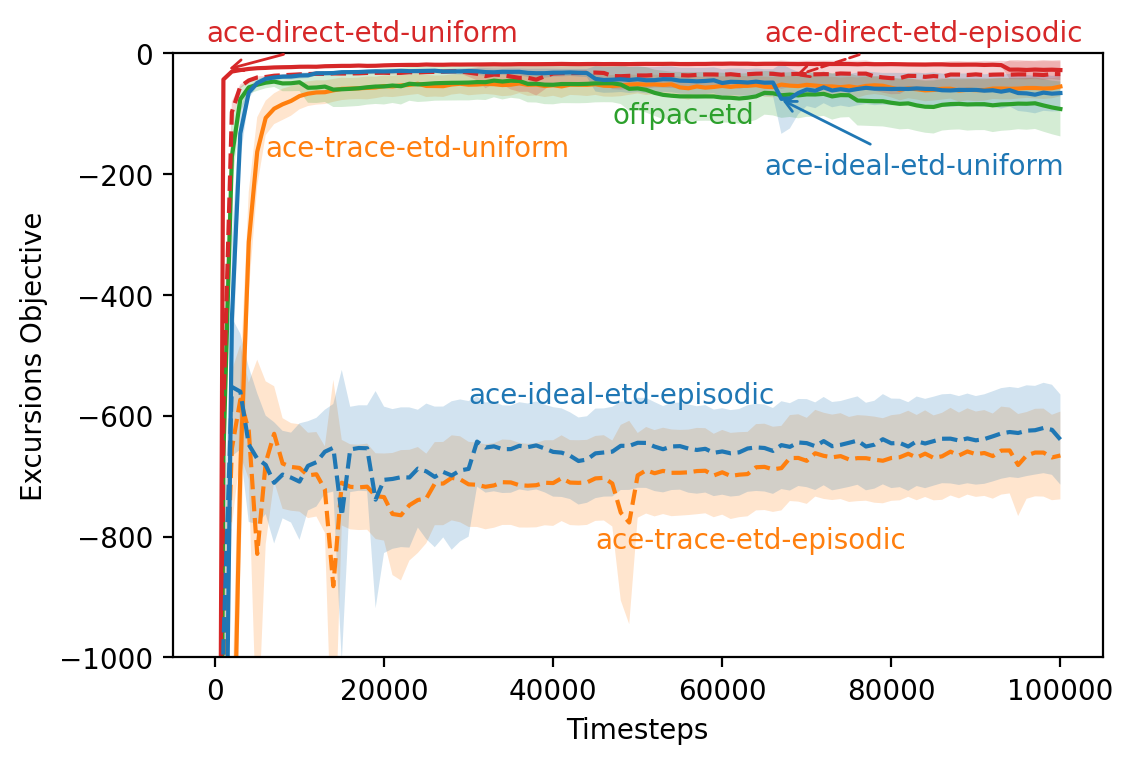

In [18]:
fig, ax = plt.subplots()
for alg in etd_algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/'+alg+'/sweep0/performance.npy', mode='r')
    results = performance['results_excursions']
    means, lower, upper = combine_results(results)
    best_config = np.nanargmax(means.sum(axis=1))
    x = np.linspace(0, 100000, 101)
    y = means[best_config]
    
    linestyle = '--' if 'episodic' in alg else '-'
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(1000, -28), xytext=(-1000, 20), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(68000, -40), xytext=(65000, 20), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'trace' in alg:
        print(alg, performance['parameters'][best_config])
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(6000, -170))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(45000, -820))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, color=color, xy=(47000, -115))
    elif 'ideal' in alg:
        print(alg, performance['parameters'][best_config])
        color = 'tab:blue'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(66500, -73), xytext=(65000, -200), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(30000, -580))
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)
    
ax.set_xlabel('Timesteps')
ax.set_ylabel('Excursions Objective')
ax.set_ylim(-1000,0)
plt.savefig('pw_exc_etd.png', bbox_inches="tight")

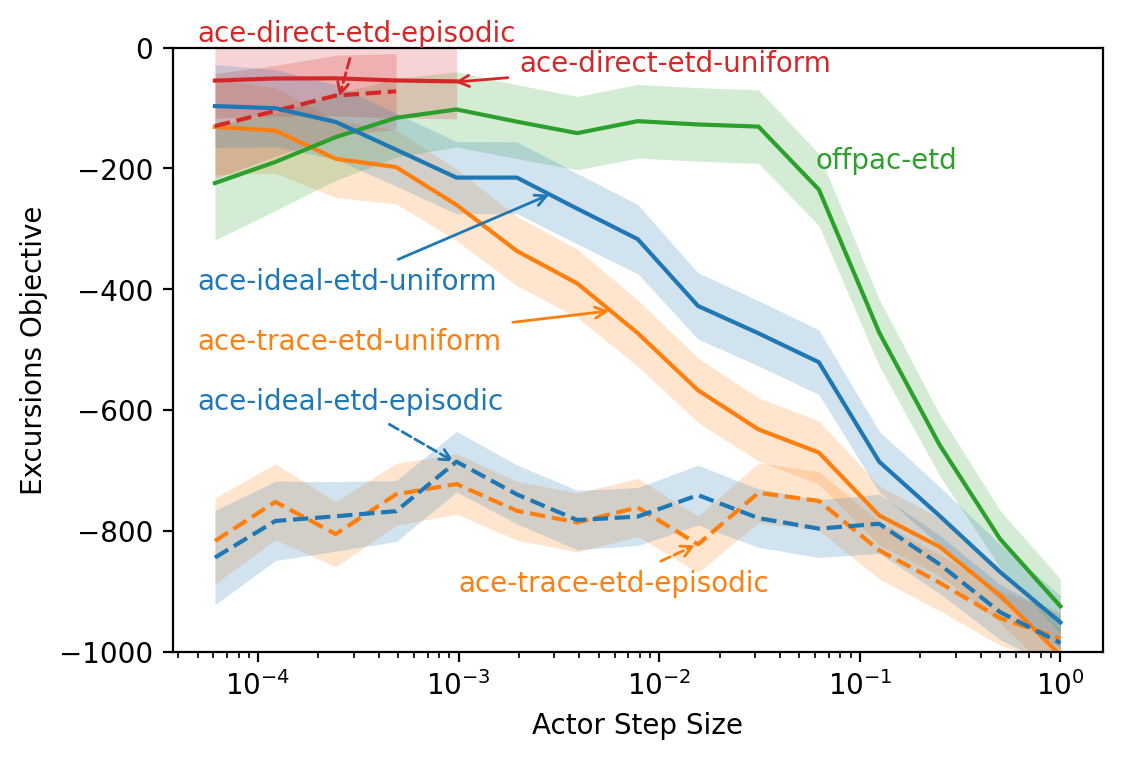

In [422]:
fig, ax = plt.subplots()
for alg in etd_algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/'+alg+'/sweep0/performance.npy', mode='r')
    results = performance['results_excursions']
    means, lower, upper = combine_results(results)
    _, num_runs, _, _ = results.shape
    mean_return = np.mean(means, axis=1)
    sem_return = st.sem(means, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_return, scale=sem_return)
    best_config = np.nanargmax(mean_return)
    
    parameters = performance['parameters']
    mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
            (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
            (parameters['lambda'] == parameters[best_config]['lambda'])
    sorted_indices = np.argsort(parameters[mask]['alpha_a'])
    
    x = parameters[mask]['alpha_a'][sorted_indices]
    y = mean_return[mask][sorted_indices]

    linestyle = '--' if 'episodic' in alg else '-'
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0009, -58), xytext=(.002, -40), arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.00025, -90), xytext=(.00005, 10), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'trace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.006, -435), xytext=(.00005, -500), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.016, -820), xytext=(.001, -900), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, color=color, xy=(.06, -200))
    elif 'ideal' in alg:
        color = 'tab:blue'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.003, -240), xytext=(.00005, -400), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.001, -690), xytext=(.00005, -600), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[mask][sorted_indices], upper[mask][sorted_indices], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Actor Step Size')
ax.set_ylabel('Excursions Objective')
ax.set_xscale('log')
ax.set_ylim(-1000,0)
plt.savefig('pw_exc_etd_sens.png', bbox_inches="tight")

ace-trace-tdrc-episodic (0.00048828, 0.125, 0., 0.5, 1., 0.95, [2, 2], 2, True)
ace-trace-tdrc-uniform 10
ace-trace-tdrc-uniform (0.00012207, 0.015625, 0., 0.75, 1., 0.95, [2, 2], 2, True)
ace-ideal-tdrc-episodic (0.00097656, 0.125, 0., 0.5, 1., 0.95, [2, 2], 2, True)
ace-ideal-tdrc-uniform 10
ace-ideal-tdrc-uniform (6.10351562e-05, 0.03125, 0., 0.5, 1., 0.95, [2, 2], 2, True)


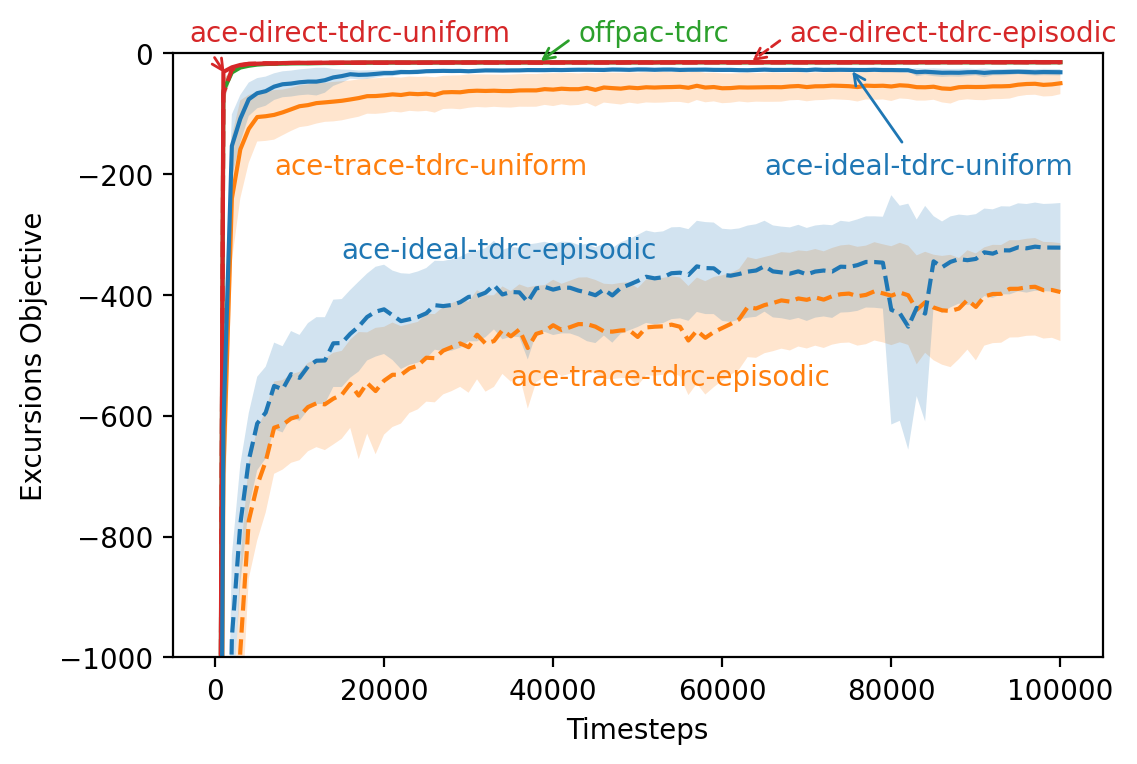

In [21]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/'+alg+'/sweep0/performance.npy', mode='r')
    results = performance['results_excursions']
    means, lower, upper = combine_results(results)
    best_config = np.nanargmax(means.sum(axis=1))
    if 'ace-trace-tdrc-uniform' in alg or 'ace-ideal-tdrc-uniform' in alg:
        print(alg, best_config)
    x = np.linspace(0, 100000, 101)
    y = means[best_config]
    
    linestyle = '--' if 'episodic' in alg else '-'
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(1500, -40), xytext=(-3000, 20), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle, relpos=(0,1)))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(63000, -18), xytext=(68000, 20), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle, relpos=(0,.5)))
    elif 'trace' in alg:
        print(alg, performance['parameters'][best_config])
        color = 'tab:orange'
        if 'uniform' in alg:
            performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/ace-trace-tdrc-uniform2/test/performance.npy', mode='r')
            results = performance['results_excursions']
            means, lower, upper = combine_results(results)
            best_config = np.nanargmax(means.sum(axis=1))
            x = np.linspace(0, 100000, 101)
            y = means[best_config]
            ax.annotate(alg, color=color, xy=(7000, -200))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(35000, -550))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, color=color, xy=(38000, -18), xytext=(43000, 20), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle, relpos=(0,.5)))
    elif 'ideal' in alg:
        print(alg, performance['parameters'][best_config])
        color = 'tab:blue'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(75000, -22), xytext=(65000, -200), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(15000, -340))
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)
    
# performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/ace-ideal-tdrc-uniform2/test/performance.npy', mode='r')
# results = performance['results_excursions']
# means, lower, upper = combine_results(results)
# best_config = np.nanargmax(means.sum(axis=1))
# x = np.linspace(0, 100000, 101)
# y = means[best_config]
# lines = ax.plot(x, y, label='ideal2')
# ax.fill_between(x, lower[best_config], upper[best_config], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)


ax.set_xlabel('Timesteps')
ax.set_ylabel('Excursions Objective')
ax.set_ylim(-1000,0)
plt.savefig('pw_exc_tdrc.png', bbox_inches="tight")

(1,)
emphatic 8.17458259719619 20.15268482934433 (6.10351562e-05, 0.03125, 0., 0.5, 1., 0.95, [2, 2], 2, True)
(15,)
ideal 7.702406606836168 10.034634846196314 (6.10351562e-05, 0.03125, 0., 0.5, 1., 0.95, [2, 2], 2, True)


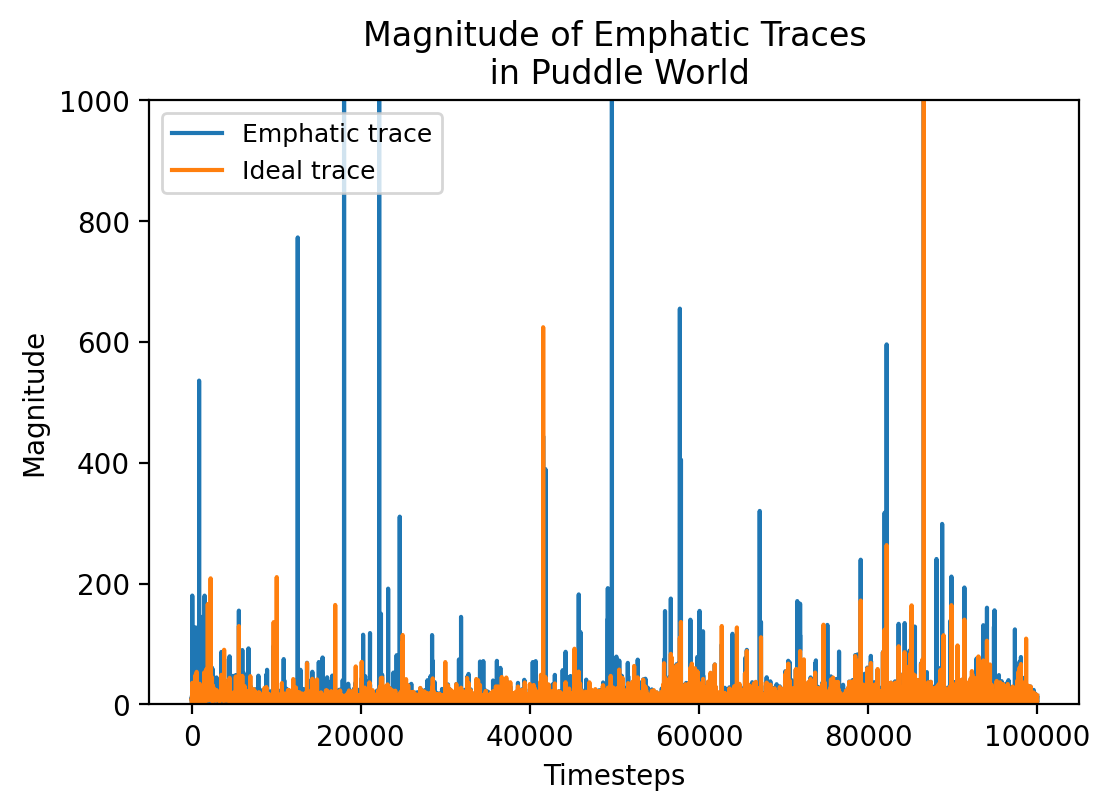

In [13]:
# Comparison of methods with the best-performing parameter settings for the ideal trace:
fig, ax = plt.subplots()

traces_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/ace-trace-tdrc-uniform2/test/traces.npy', mode='r')
print(traces_memmap.shape)
traces = traces_memmap[0]['traces']
mean_traces = np.mean(traces, axis=0)
print('emphatic', np.mean(mean_traces), np.std(mean_traces), traces_memmap[0]['parameters'])
ax.plot(mean_traces, label='Emphatic trace')

ideal_traces_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/ace-ideal-tdrc-uniform2/sweep0/traces.npy', mode='r')
print(ideal_traces_memmap.shape)
ideal_traces = ideal_traces_memmap[10]['traces']
ideal_mean_traces = np.mean(ideal_traces, axis=0)
print('ideal', np.mean(ideal_mean_traces), np.std(ideal_mean_traces), ideal_traces_memmap[10]['parameters'])
ax.plot(ideal_mean_traces, label='Ideal trace')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Magnitude')
ax.set_ylim(0,1000)
ax.set_title('Magnitude of Emphatic Traces\n in Puddle World')
plt.legend()
plt.show()

(15,)
ace-ideal-tdrc-uniform 8.039587339671186 23.999608584467243 (0.00012207, 0.015625, 0., 0.75, 1., 0.95, [2, 2], 2, True)
(1,)
ace-ideal-tdrc-uniform 7.575562164641365 17.976245609182588 (0.00012207, 0.015625, 0., 0.75, 1., 0.95, [2, 2], 2, True)


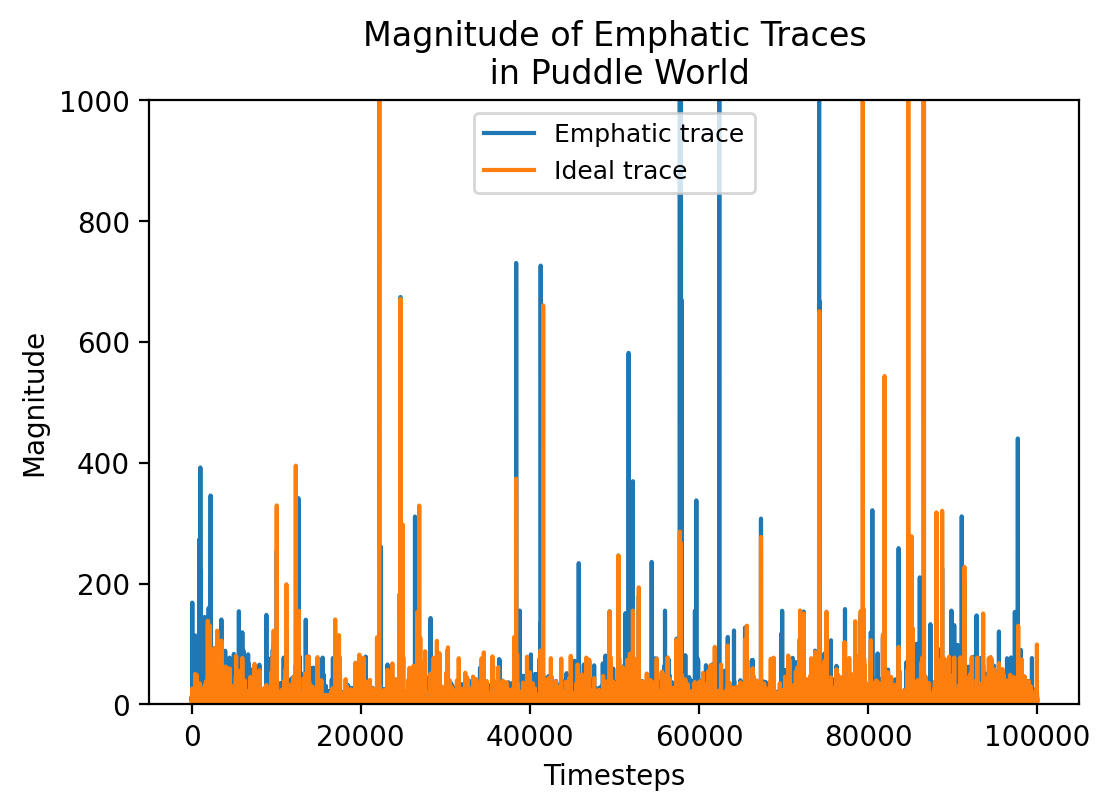

In [10]:
# Comparison of methods with the best-performing parameter settings for the emphatic trace:
fig, ax = plt.subplots()

traces_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/ace-trace-tdrc-uniform2/sweep0/traces.npy', mode='r')
print(traces_memmap.shape)
traces = traces_memmap[10]['traces']
mean_traces = np.mean(traces, axis=0)
print(alg, np.mean(mean_traces), np.std(mean_traces), traces_memmap[10]['parameters'])
ax.plot(mean_traces, label='Emphatic trace')

ideal_traces_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/ace-ideal-tdrc-uniform2/test/traces.npy', mode='r')
print(ideal_traces_memmap.shape)
ideal_traces = ideal_traces_memmap[0]['traces']
ideal_mean_traces = np.mean(ideal_traces, axis=0)
print(alg, np.mean(ideal_mean_traces), np.std(ideal_mean_traces), ideal_traces_memmap[0]['parameters'])
ax.plot(ideal_mean_traces, label='Ideal trace')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Magnitude')
ax.set_ylim(0,1000)
ax.set_title('Magnitude of Emphatic Traces\n in Puddle World')
plt.legend()
plt.show()

ace-trace-tdrc-uniform 8.039587339671186 23.999608584467243 (0.00012207, 0.015625, 0., 0.75, 1., 0.95, [2, 2], 2, True)
ace-ideal-tdrc-uniform 7.702406606836168 10.034634846196314 (6.10351562e-05, 0.03125, 0., 0.5, 1., 0.95, [2, 2], 2, True)


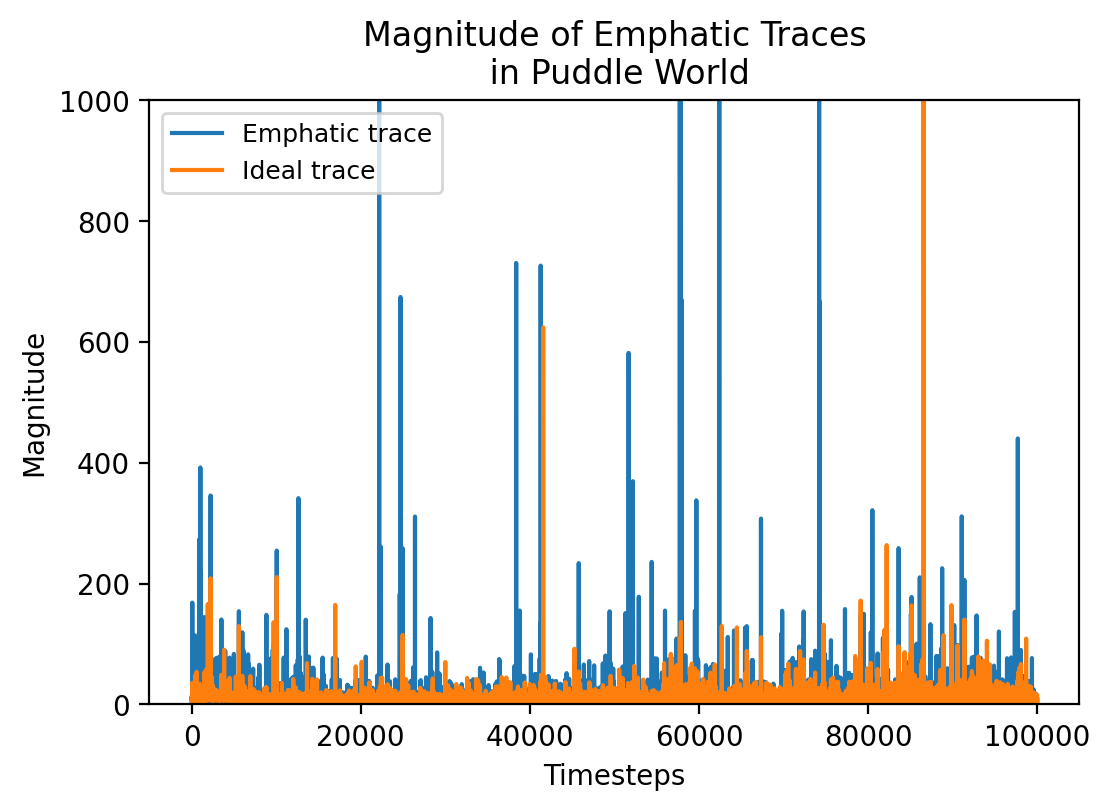

In [5]:
# Comparison of best-performing parameter settings:
fig, ax = plt.subplots()
for alg in ['ace-trace-tdrc-uniform', 'ace-ideal-tdrc-uniform']:
    traces_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/'+alg+'2/sweep0/traces.npy', mode='r')
    traces = traces_memmap[10]['traces']
    mean_traces = np.mean(traces, axis=0)
    print(alg, np.mean(mean_traces), np.std(mean_traces), traces_memmap[10]['parameters'])
    ax.plot(mean_traces, label='Emphatic trace' if 'trace' in alg else 'Ideal trace')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Magnitude')
ax.set_ylim(0,1000)
ax.set_title('Magnitude of Emphatic Traces\n in Puddle World')
plt.legend()
plt.show()


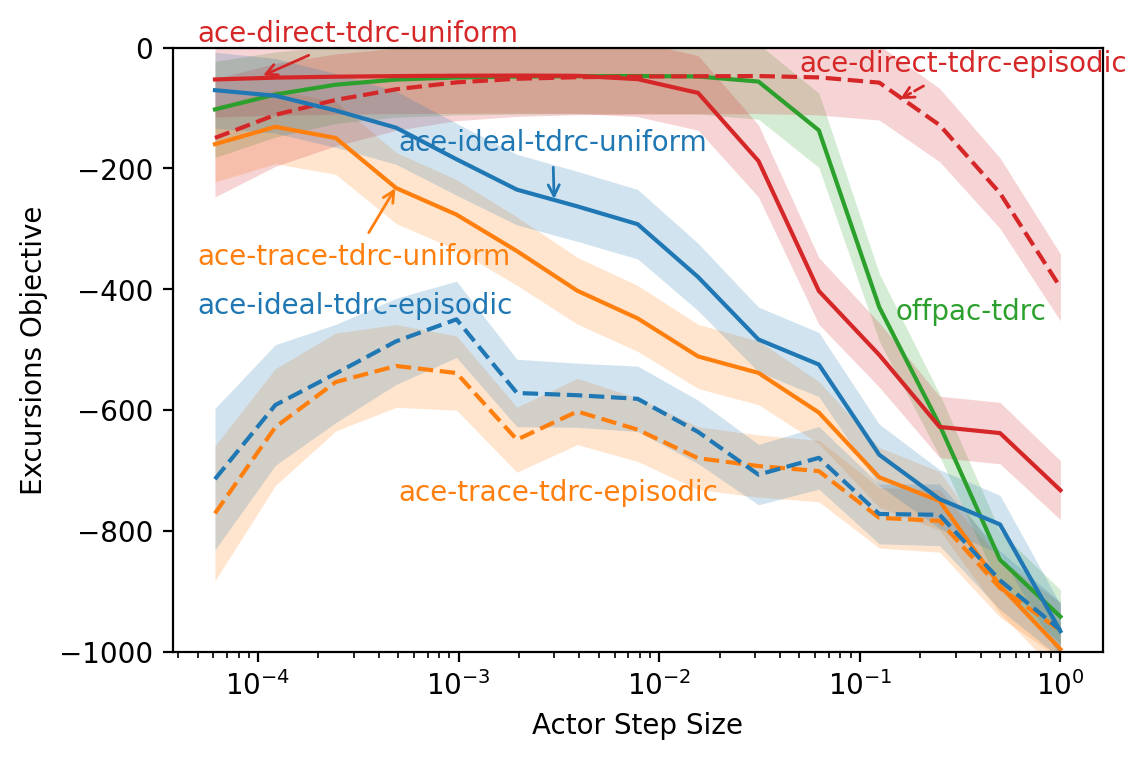

In [23]:
fig, ax = plt.subplots()
for alg in tdrc_algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/'+alg+'/sweep0/performance.npy', mode='r')
#     if 'ace-trace-tdrc-uniform' in alg:
#         performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/ace-trace-tdrc-uniform2/test/performance.npy', mode='r')
    
    results = performance['results_excursions']
    means, lower, upper = combine_results(results)
    _, num_runs, _, _ = results.shape
    mean_return = np.mean(means, axis=1)
    sem_return = st.sem(means, axis=1)
    lower, upper = st.t.interval(0.95, num_runs-1, loc=mean_return, scale=sem_return)
    best_config = np.nanargmax(mean_return)
    
    parameters = performance['parameters']
    mask = (parameters['alpha_w'] == parameters[best_config]['alpha_w']) & \
            (parameters['alpha_v'] == parameters[best_config]['alpha_v']) & \
            (parameters['lambda'] == parameters[best_config]['lambda'])
    sorted_indices = np.argsort(parameters[mask]['alpha_a'])
    
    x = parameters[mask]['alpha_a'][sorted_indices]
    y = mean_return[mask][sorted_indices]

    linestyle = '--' if 'episodic' in alg else '-'
    if 'direct' in alg:
        color = 'tab:red'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0001, -50), xytext=(.00005, 10), arrowprops=dict(arrowstyle="->", color=color))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.15, -90), xytext=(.05, -40), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
    elif 'trace' in alg:
        color = 'tab:orange'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.0005, -225), xytext=(.00005, -360), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.0005, -750))
    elif 'offpac' in alg:
        color = 'tab:green'
        ax.annotate(alg, color=color, xy=(.15, -450))
    elif 'ideal' in alg:
        color = 'tab:blue'
        if 'uniform' in alg:
            ax.annotate(alg, color=color, xy=(.003, -260), xytext=(.0005, -170), arrowprops=dict(arrowstyle="->", color=color, linestyle=linestyle))
        elif 'episodic' in alg:
            ax.annotate(alg, color=color, xy=(.00005, -440))
    lines = ax.plot(x, y, label=alg, linestyle=linestyle, color=color)
    ax.fill_between(x, lower[mask][sorted_indices], upper[mask][sorted_indices], alpha=0.2, facecolor=lines[0]._color, edgecolor=lines[0]._color, linewidth=0)

ax.set_xlabel('Actor Step Size')
ax.set_ylabel('Excursions Objective')
ax.set_xscale('log')
ax.set_ylim(-1000,0)
plt.savefig('pw_exc_tdrc_sens.png', bbox_inches="tight")

In [473]:
# Code to print best-performing episodic parameters:
for alg in algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw_100ksteps_30runs/bias/eval_episodic/'+alg+'/sweep0/performance.npy', mode='r')
    print(alg, performance['parameters'])

ace-trace-etd-episodic [(6.10351562e-05, 0.5, 0., 0.875, 1., 0.95, [2, 2], 2,  True)]
ace-trace-etd-uniform [(6.10351562e-05, 0.00390625, 0., 0.875, 1., 0.95, [2, 2], 2,  True)]
offpac-etd [(0.00097656, 0.00195312, 0., 0., 0., 0.95, [2, 2], 2,  True)]
ace-direct-etd-episodic [(0.00097656, 1., 0.03125, 0.5, 1., 0.95, [2, 2], 2,  True)]
ace-direct-etd-uniform [(0.00195312, 0.03125, 0.03125, 0., 1., 0.95, [2, 2], 2,  True)]
ace-ideal-etd-episodic [(6.10351562e-05, 0.25, 0., 0.875, 1., 0.95, [2, 2], 2,  True)]
ace-ideal-etd-uniform [(6.10351562e-05, 0.0078125, 0., 0.875, 1., 0.95, [2, 2], 2,  True)]
ace-trace-tdrc-episodic [(0.00048828, 0.125, 0., 0.5, 1., 0.95, [2, 2], 2,  True)]
ace-trace-tdrc-uniform [(6.10351562e-05, 0.015625, 0., 0.75, 1., 0.95, [2, 2], 2,  True)]
offpac-tdrc [(0.015625, 0.125, 0., 0.5, 0., 0.95, [2, 2], 2,  True)]
ace-direct-tdrc-episodic [(0.03125, 0.125, 0.03125, 0.5, 1., 0.95, [2, 2], 2,  True)]
ace-direct-tdrc-uniform [(0.00390625, 0.25, 0.03125, 0., 1., 0.95, [2

In [474]:
# Code to print best-performing excursions parameters:
for alg in algs:
    performance = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw_100ksteps_30runs/bias/eval_excursions/'+alg+'/0/performance.npy', mode='r')
    print(alg, performance['parameters'])

ace-trace-etd-episodic [(0.00012207, 1., 0., 0.9375, 1., 0.95, [2, 2], 2,  True)]
ace-trace-etd-uniform [(6.10351562e-05, 0.00048828, 0., 0., 1., 0.95, [2, 2], 2,  True)]
offpac-etd [(0.00097656, 0.00195312, 0., 0., 0., 0.95, [2, 2], 2,  True)]
ace-direct-etd-episodic [(0.00097656, 1., 0.03125, 0.5, 1., 0.95, [2, 2], 2,  True)]
ace-direct-etd-uniform [(0.00195312, 0.03125, 0.03125, 0., 1., 0.95, [2, 2], 2,  True)]
ace-ideal-etd-episodic [(0.00097656, 1., 0., 0.5, 1., 0.95, [2, 2], 2,  True)]
ace-ideal-etd-uniform [(6.10351562e-05, 0.00195312, 0., 0., 1., 0.95, [2, 2], 2,  True)]
ace-trace-tdrc-episodic [(0.00048828, 0.125, 0., 0.5, 1., 0.95, [2, 2], 2,  True)]
ace-trace-tdrc-uniform [(6.10351562e-05, 0.015625, 0., 0.75, 1., 0.95, [2, 2], 2,  True)]
offpac-tdrc [(0.015625, 0.0625, 0., 0., 0., 0.95, [2, 2], 2,  True)]
ace-direct-tdrc-episodic [(0.0625, 0.125, 0.03125, 0., 1., 0.95, [2, 2], 2,  True)]
ace-direct-tdrc-uniform [(0.00195312, 0.125, 0.03125, 0., 1., 0.95, [2, 2], 2,  True)]
a

In [46]:
performance = np.lib.format.open_memmap('/scratch/s/sutton/graves/actor-critic-with-emphatic-weightings/pw-final-episodic/offpac-etd/sweep0/performance.npy', mode='r')
print(performance.shape)
print(performance.dtype)

(15,)
[('parameters', [('alpha_a', '<f8'), ('alpha_w', '<f8'), ('alpha_v', '<f8'), ('lambda', '<f8'), ('eta', '<f8'), ('gamma', '<f8'), ('num_tiles_per_dim', '<i8', (2,)), ('num_tilings', '<i8'), ('bias_unit', '?')]), ('results', '<f8', (50, 101, 50)), ('results_excursions', '<f8', (50, 101, 50))]


In [16]:
experience = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/mountain-car/ace-direct-etd-uniform/experience_test.npy', mode='r')
states = []
for run in experience:
    for state in run:
        states.append(*state)
states = np.array(states).T
# print(states)

(30, 50)


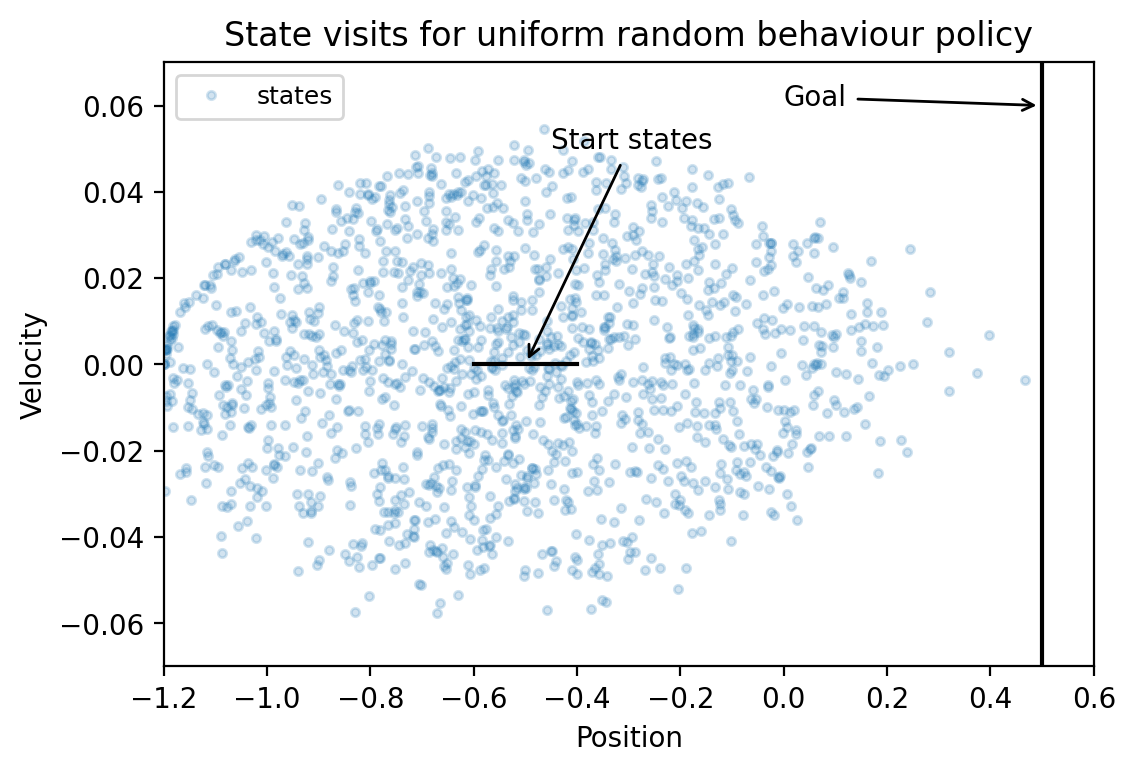

In [19]:
import gym

experience = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/pw-final-excursions/offpac-etd/experience_test.npy', mode='r')
print(experience.shape)
states = []
for run in experience:
    for state in run:
        states.append(*state)
states = np.array(states).T

mc = gym.make('MountainCar-v0').unwrapped
fig = plt.figure()
ax = fig.gca()
ax.plot(states[0], states[1], '.', alpha=.2, label='states')
plt.title('State visits for uniform random behaviour policy')
plt.xlabel('Position')
plt.xlim(mc.min_position, mc.max_position)
plt.ylabel('Velocity')
plt.ylim(-mc.max_speed, mc.max_speed)
ax.plot((-.6,-.4), (0,0), color='black')
ax.annotate('Start states', xy=(-.5,0), xytext=(-.45, .05), arrowprops=dict(arrowstyle='->'))
plt.axvline(x=mc.goal_position, color='black')  # Plot the goal position.
ax.annotate('Goal', xy=(mc.goal_position, .06), xytext=(.0, .06), arrowprops=dict(arrowstyle='->'))
plt.legend(loc='upper left')
mc.close()
plt.show()

In [ ]:
# # Do any of the offpac runs diverge?
# op_memmap = np.lib.format.open_memmap('/home/s/sutton/graves/scratch/actor-critic-with-emphatic-weightings/virtual-office4/offpac/concatenated_performance.npy', mode='r')
# op_results = op_memmap['performance']['results']
# op_num_configs, op_num_runs, op_num_policies, op_num_eval_runs = op_results.shape

# print(np.isnan(op_memmap['performance']).sum() / op_results)

# # op_parameters = op_memmap['parameters']

In [ ]:
# print(np.isnan(op_mean_results).any(axis=1).sum())
# print(op_parameters.dtype.names)
# print(op_parameters[np.isnan(op_mean_results).any(axis=1)])